<a href="https://colab.research.google.com/github/cintramousike-prog/ServiceDesk_Assistant_AI/blob/main/Imers%C3%A3o_Agentes_IA-Alura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LLM GOOGLE GEMINI**

In [1]:
!pip install -q --upgrade langchain langchain-google-genai google-generativeai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.7 MB/s eta 0:00:00


Importação da API Key:

In [3]:
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI

GOOGLE_API_KEY = userdata.get('GEMINI_API_KEY')

In [4]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=1.0,
    api_key=GOOGLE_API_KEY
)

In [5]:
resp_test = llm.invoke("Qual a moeda do futuro?")
print(resp_test.content)

Não há uma única "moeda do futuro" definida, mas sim uma evolução complexa e multifacetada do conceito de dinheiro. Várias tendências e tecnologias estão moldando o que pode ser a moeda predominante em diferentes contextos, ou talvez um sistema híbrido.

Aqui estão os principais candidatos e conceitos que apontam para a "moeda do futuro":

1.  **Moedas Digitais de Banco Central (CBDCs - Central Bank Digital Currencies):**
    *   **O que são:** Versões digitais das moedas fiduciárias existentes (dólar, euro, real, etc.), emitidas e garantidas pelos bancos centrais. Seriam uma forma de "dinheiro em espécie digital", diretamente acessível ao público.
    *   **Vantagens:** Estabilidade (sem volatilidade das criptomoedas), segurança (garantida pelo estado), eficiência em pagamentos, inclusão financeira, capacidade de implementar políticas monetárias mais diretas e transparentes.
    *   **Desafios:** Preocupações com a privacidade (controle governamental sobre as transações), impacto no s

In [35]:
TRIAGEM_PROMPT = (
    "Você é um triador de Service Desk para políticas internas da empresa Course Builds. "
    "Dada a mensagem do usuário, retorne SOMENTE um JSON com:\n"
    "{\n"
    '  "decisao": "AUTO_RESOLVER" | "PEDIR_INFO" | "ABRIR_CHAMADO",\n'
    '  "urgencia": "BAIXA" | "MEDIA" | "ALTA",\n'
    '  "campos_faltantes": ["..."]\n'
    "}\n"
    "Regras:\n"
    '- **AUTO_RESOLVER**: Perguntas claras sobre regras ou procedimentos descritos nas políticas (Ex: "Posso reembolsar a internet do meu home office?", "Como funciona a política de alimentação em viagens?").\n'
    '- **PEDIR_INFO**: Mensagens vagas ou que faltam informações para identificar o tema ou contexto (Ex: "Preciso de ajuda com uma política", "Tenho uma dúvida geral").\n'
    '- **ABRIR_CHAMADO**: Pedidos de exceção, liberação, aprovação ou acesso especial, ou quando o usuário explicitamente pede para abrir um chamado (Ex: "Quero exceção para trabalhar 5 dias remoto.", "Solicito liberação para anexos externos.", "Por favor, abra um chamado para o RH.").'
    "Analise a mensagem e decida a ação mais apropriada."
)

In [7]:
from dataclasses import field
from pydantic import BaseModel, Field
from typing import Literal, List, Dict

class TriagemOut(BaseModel):
  decisao: Literal["AUTO_RESOLVER", "PEDIR_INFO", "ABRIR_CHAMADO"]
  urgencia: Literal["BAIXA", "MEDIA", "ALTA"]
  campos_faltantes: List[str] = Field(default_factory=list)

In [8]:
llm_triagem = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0.0,
    api_key=GOOGLE_API_KEY
)

In [9]:
from langchain_core.messages import SystemMessage, HumanMessage

triagem_chain = llm_triagem.with_structured_output(TriagemOut)

def triagem(mensagem: str) -> Dict:
  saida: TriagemOut = triagem_chain.invoke([
      SystemMessage(content=TRIAGEM_PROMPT),
      HumanMessage(content=mensagem)
  ])

  return saida.model_dump()

In [10]:
testes = ["Posso reembolsar a internet?",
          "Quero mais 5 dias de trabalho remoto. Como faço?",
          "Posso reembolsar cursos ou treinamentos da Alura?",
          "Quantas capivaras tem no Rio Pinheiros?"]

In [11]:
for msg_teste in testes:
  print(f"Pergunta: {msg_teste}\n -> Resposta: {triagem(msg_teste)}\n")

Pergunta: Posso reembolsar a internet?
 -> Resposta: {'decisao': 'AUTO_RESOLVER', 'urgencia': 'BAIXA', 'campos_faltantes': []}

Pergunta: Quero mais 5 dias de trabalho remoto. Como faço?
 -> Resposta: {'decisao': 'ABRIR_CHAMADO', 'urgencia': 'MEDIA', 'campos_faltantes': []}

Pergunta: Posso reembolsar cursos ou treinamentos da Alura?
 -> Resposta: {'decisao': 'AUTO_RESOLVER', 'urgencia': 'BAIXA', 'campos_faltantes': []}

Pergunta: Quantas capivaras tem no Rio Pinheiros?
 -> Resposta: {'decisao': 'PEDIR_INFO', 'urgencia': 'BAIXA', 'campos_faltantes': ['Assunto relacionado às políticas internas da empresa']}



# **RAG**

In [12]:
!pip install -q --upgrade pymupdf requests==2.32.4 langchain_community faiss-cpu langchain-text-splitters

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.2 MB/s eta 0:00:00


In [13]:
from pathlib import Path
from langchain_community.document_loaders import PyMuPDFLoader

docs = []

for ndocs in Path("/content/").glob("*.pdf"):
    try:
        loader = PyMuPDFLoader(str(ndocs))
        docs.extend(loader.load())
        print(f"Carregado com sucesso arquivo {ndocs.name}")
    except Exception as e:
        print(f"Erro ao carregar arquivo {ndocs.name}: {e}")

print(f"Total de documentos carregados: {len(docs)}")

Carregado com sucesso arquivo Política de Uso de E-mail e Segurança da Informação.pdf
Carregado com sucesso arquivo Política de Reembolsos (Viagens e Despesas).pdf
Carregado com sucesso arquivo Políticas de Home Office.pdf
Total de documentos carregados: 3


In [14]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=30)

chunks = splitter.split_documents(docs)

In [15]:
for chunk in chunks:
  print(chunk)
  print("  ---  ")

page_content='Política de Uso de E-mail e Segurança 
da Informação 
 
1.​ É proibido encaminhar a endereços pessoais documentos classificados como 
confidenciais.​
 
2.​ Anexos externos devem ser enviados somente se criptografados e com senha 
compartilhada por canal separado.​' metadata={'producer': 'Skia/PDF m140 Google Docs Renderer', 'creator': '', 'creationdate': '', 'source': '/content/Política de Uso de E-mail e Segurança da Informação.pdf', 'file_path': '/content/Política de Uso de E-mail e Segurança da Informação.pdf', 'total_pages': 1, 'format': 'PDF 1.4', 'title': 'Imersão: Política de Uso de E-mail e Segurança da Informação', 'author': '', 'subject': '', 'keywords': '', 'moddate': '', 'trapped': '', 'modDate': '', 'creationDate': '', 'page': 0}
  ---  
page_content='3.​ Phishing: verifique remetente e domínios suspeitos. Reporte mensagens suspeitas 
ao time de Segurança imediatamente.​
 
4.​ Retenção: mensagens que contenham dados pessoais devem seguir as diretrizes 
de ret

In [16]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(
    model="models/gemini-embedding-001",
    google_api_key=GOOGLE_API_KEY
)

In [17]:
from langchain_community.vectorstores import FAISS

vectorstore = FAISS.from_documents(chunks, embeddings)

retriever = vectorstore.as_retriever(search_type="similarity_score_threshold",
                                     search_kwargs={"score_threshold":0.3, "k":4})

In [18]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain

prompt_rag = ChatPromptTemplate.from_messages([
    ("system",
     "Você é um Assistente de Políticas Internas (RH/IT) da empresa Blockchain Builds."
     "Responda SOMENTE com base no contexto fornecido. "
     "Se não houver base suficiente, responda apenas 'Não sei'."),

    ("human", "Pergunta: {input}\n\nContexto:\n{context}")
])

document_chain = create_stuff_documents_chain(llm_triagem, prompt_rag)

In [19]:
# Formatadores
import re, pathlib

def _clean_text(s: str) -> str:
    return re.sub(r"\s+", " ", s or "").strip()

def extrair_trecho(texto: str, query: str, janela: int = 240) -> str:
    txt = _clean_text(texto)
    termos = [t.lower() for t in re.findall(r"\w+", query or "") if len(t) >= 4]
    pos = -1
    for t in termos:
        pos = txt.lower().find(t)
        if pos != -1: break
    if pos == -1: pos = 0
    ini, fim = max(0, pos - janela//2), min(len(txt), pos + janela//2)
    return txt[ini:fim]

def formatar_citacoes(docs_rel: List, query: str) -> List[Dict]:
    cites, seen = [], set()
    for d in docs_rel:
        src = pathlib.Path(d.metadata.get("source","")).name
        page = int(d.metadata.get("page", 0)) + 1
        key = (src, page)
        if key in seen:
            continue
        seen.add(key)
        cites.append({"documento": src, "pagina": page, "trecho": extrair_trecho(d.page_content, query)})
    return cites[:3]

In [20]:
def perguntar_politica_RAG(pergunta: str) -> Dict:
    docs_relacionados = retriever.invoke(pergunta)

    if not docs_relacionados:
      return {"answer": "Não sei.", "citacoes": [], "contexto_encontrado": False}

    answer = document_chain.invoke({"input": pergunta, "context": docs_relacionados})

    txt = (answer or "").strip()

    if txt.rstrip(".!?") == "Não sei":
      return {"answer": "Não sei.", "citacoes": [], "contexto_encontrado": False}

    return {"answer": txt, "citacoes": formatar_citacoes(docs_relacionados, pergunta), "contexto_encontrado": True}

In [21]:
for msg_teste in testes:
  resposta = perguntar_politica_RAG(msg_teste)
  print(f"PERGUNTA: {msg_teste}")
  print(f"RESPOSTA: {resposta ['answer']}")
  if resposta ['contexto_encontrado']:
    print("CITAÇÕES:")
    for citacoes in resposta['citacoes']:
      print(f"  - Documento: {citacoes['documento']}, Página: {citacoes['pagina']}")
      print(f"    Trecho: {citacoes['trecho']}")
    print("    -  -  -  -  - - - - - -  -    ")

PERGUNTA: Posso reembolsar a internet?
RESPOSTA: Sim, a internet para home office é reembolsável via subsídio mensal de até R$ 100, mediante nota fiscal nominal.
CITAÇÕES:
  - Documento: Política de Reembolsos (Viagens e Despesas).pdf, Página: 1
    Trecho: lsáveis.​ 3.​ Transporte: táxi/app são permitidos quando não houver alternativa viável. Comprovantes obrigatórios.​ 4.​ Internet para home office: reembolsável via subsídio mensal de até R$ 100, conforme política de Home Office.​
  - Documento: Políticas de Home Office.pdf, Página: 1
    Trecho: 5.​ Conectividade: há subsídio mensal de internet domiciliar para quem trabalha em home office: até R$ 100/mês, mediante nota fiscal nominal.​ 6.​ Solicitação de
    -  -  -  -  - - - - - -  -    
PERGUNTA: Quero mais 5 dias de trabalho remoto. Como faço?
RESPOSTA: Para solicitar mais 5 dias de trabalho remoto, você deve formalizar a solicitação via chamado ao RH com a justificativa do seu gestor.
CITAÇÕES:
  - Documento: Políticas de Home O

# **LANGGRAPH**

In [22]:
!pip install -q --upgrade langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 15.1 MB/s eta 0:00:00


In [23]:
from typing import TypedDict, Optional

class AgentState(TypedDict, total = False):
    pergunta: str
    triagem: dict
    resposta: Optional[str]
    citacoes: List[dict]
    rag_sucesso: bool
    acao_final: str



In [24]:
def node_triagem(state: AgentState) -> AgentState:
    print("Executando nó de triagem...")
    return {"triagem": triagem(state["pergunta"])}

In [25]:
def node_auto_resolver(state: AgentState) -> AgentState:
    print("Executando nó de auto_resolver...")
    resposta_RAG = perguntar_politica_RAG(state["pergunta"])

    update: AgentState = {
        "resposta": resposta_RAG["answer"],
        "citacoes": resposta_RAG.get("citacoes", []),
        "rag_sucesso": resposta_RAG["contexto_encontrado"],
    }

    if resposta_RAG["contexto_encontrado"]:
        update["acao_final"] = "AUTO_RESOLVER"

    return update

In [26]:
def node_pedir_info(state: AgentState) -> AgentState:
    print("Executando nó de pedir_info...")
    faltantes = state["triagem"].get("campos_faltantes", [])
    if faltantes:
        detalhe = ",".join(faltantes)
    else:
        detalhe = "Tema e contexto específico"

    return {
        "resposta": f"Para vançar, preciso que você detalhe o que está faltando: {detalhe}",
        "citacoes": [],
        "acao_final": "PEDIR_INFO"
    }

In [27]:
def node_abrir_chamado(state: AgentState) -> AgentState:
    print("Executando nó de abrir_chamdo...")
    triagem = state["triagem"]

    return {
        "resposta": f"Abrindo chamado para urgência {triagem['urgencia']}. Descrição: {state['pergunta'][:14]}",
        "citacoes": [],
        "acao_final": "ABRIR_CHAMADO"
    }

In [28]:
KEYWORDS_ABRIR_TICKET = ["aprovação", "liberação", "exceção", "acesso especial", "abrir chamado", "abrir ticket", "acesso especial"]

def decidir_pos_triagem(state: AgentState) -> str:
    print("Decidindo após a triagem")
    decisao = state["triagem"]["decisao"]

    if decisao == "AUTO_RESOLVER": return "resolver"
    if decisao == "PEDIR_INFO": return "info"
    if decisao == "ABRIR_CHAMADO": return "chamado"

In [29]:
def decidir_pos_auto_resolver(state: AgentState) -> str:
    print("Decidindo após o auto resolver...")

    if state.get("rag_sucesso"):
        print("Rag com sucesso, finalizando o fluxo.")
        return "ok"

    state_da_pergunta = (state["pergunta"] or "").lower()

    if any(k in state_da_pergunta for k in KEYWORDS_ABRIR_TICKET):
        print("Rag falhou, mas foram encontradas keywords de abertura de ticket. Abrindo...")
        return "chamado"

    print("Rag falhou, sem keywords. Vou pedir mais informações...")
    return "info"

In [30]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(AgentState)

workflow.add_node("triagem", node_triagem)
workflow.add_node("auto_resolver", node_auto_resolver)
workflow.add_node("pedir_info", node_pedir_info)
workflow.add_node("abrir_chamado", node_abrir_chamado)

workflow.add_edge(START, "triagem")
workflow.add_conditional_edges("triagem", decidir_pos_triagem, {
    "resolver": "auto_resolver",
    "info": "pedir_info",
    "chamado": "abrir_chamado"
})

workflow.add_conditional_edges("auto_resolver", decidir_pos_auto_resolver, {
    "info": "pedir_info",
    "chamado": "abrir_chamado",
    "ok": END
})

workflow.add_edge("pedir_info", END)
workflow.add_edge("abrir_chamado", END)

grafo = workflow.compile()

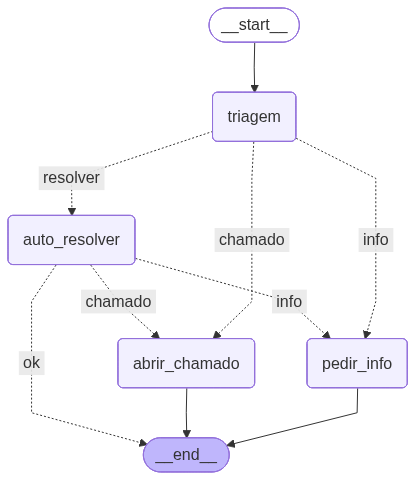

In [31]:
from IPython.display import display, Image

graph_bytes = grafo.get_graph().draw_mermaid_png()
display(Image(graph_bytes))

In [32]:
testes = ["Posso reembolsar a internet?",
          "Quero mais 5 dias de trabalho remoto. Como faço?",
          "Posso reembolsar cursos ou treinamentos da Alura?",
          "É possível reembolsar certificações do Google Cloud?",
          "Posso obter o Google Gemini de graça?",
          "Qual é a palavra-chave da aula de hoje?",
          "Quantas capivaras tem no Rio Pinheiros?"]

In [33]:
for msg_test in testes:
    resposta_final = grafo.invoke({"pergunta": msg_test})

    triag = resposta_final.get("triagem", {})
    print(f"PERGUNTA: {msg_test}")
    print(f"DECISÃO: {triag.get('decisao')} | URGÊNCIA: {triag.get('urgencia')} | AÇÃO FINAL: {resposta_final.get('acao_final')}")
    print(f"RESPOSTA: {resposta_final.get('resposta')}")
    if resposta_final.get("citacoes"):
        print("CITAÇÕES:")
        for citacao in resposta_final.get("citacoes"):
            print(f"  - Documento: {citacao['documento']}, Página: {citacao['pagina']}")
            print(f"    Trecho: {citacao['trecho']}")

    print("    -  -  -  -  - - - - - -  -    ")

Executando nó de triagem...
Decidindo após a triagem
Executando nó de auto_resolver...
Decidindo após o auto resolver...
Rag com sucesso, finalizando o fluxo.
PERGUNTA: Posso reembolsar a internet?
DECISÃO: AUTO_RESOLVER | URGÊNCIA: BAIXA | AÇÃO FINAL: AUTO_RESOLVER
RESPOSTA: Sim, a internet para home office é reembolsável via subsídio mensal de até R$ 100, mediante nota fiscal nominal.
CITAÇÕES:
  - Documento: Política de Reembolsos (Viagens e Despesas).pdf, Página: 1
    Trecho: lsáveis.​ 3.​ Transporte: táxi/app são permitidos quando não houver alternativa viável. Comprovantes obrigatórios.​ 4.​ Internet para home office: reembolsável via subsídio mensal de até R$ 100, conforme política de Home Office.​
  - Documento: Políticas de Home Office.pdf, Página: 1
    Trecho: 5.​ Conectividade: há subsídio mensal de internet domiciliar para quem trabalha em home office: até R$ 100/mês, mediante nota fiscal nominal.​ 6.​ Solicitação de
    -  -  -  -  - - - - - -  -    
Executando nó de tri